In [4]:
import decimal
from collections import defaultdict
import matplotlib
import numpy as np
import itertools
import os
import pandas as pd
import datetime
from joblib import dump
import json
from matplotlib import pyplot as plt
from tqdm import tqdm
import glob
import pdb
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.metrics import fbeta_score, classification_report, confusion_matrix
from catboost import CatBoostClassifier
from catboost import Pool, CatBoostRegressor
from sklearn.metrics import roc_curve, auc
import sys
import warnings
warnings.filterwarnings('ignore')
sys.path.insert(0, '../../scripts/modeling_toolbox/')
sys.path.insert(0, '../../')
import utils
from scripts.asset_processor import VideoAssetProcessor

%matplotlib notebook
matplotlib.style.use('ggplot')
matplotlib.rcParams['figure.figsize']=[10,6]
pd.options.display.width = 0
pd.set_option('display.max_columns', None)

In [5]:
%matplotlib notebook

In [6]:
FEATURES_UL = ['size_dimension_ratio',
               'temporal_dct-mean',
               'temporal_gaussian_mse-mean',
               'temporal_gaussian_difference-mean',
               'temporal_threshold_gaussian_difference-mean'
               ]

FEATURES_SL = ['temporal_dct-mean',
               'temporal_gaussian_mse-mean',
               'temporal_gaussian_difference-mean',
               'temporal_threshold_gaussian_difference-mean'
               ]
FEATURES_QOE = ['temporal_dct-mean',
            'temporal_gaussian_mse-mean',
            'temporal_gaussian_difference-mean',
            'temporal_threshold_gaussian_difference-mean'
            ]
FEATURES_META = ['cat_r_pred','cat_cl_pred','ocsvm_pred']
METRICS_QOE = ['temporal_ssim-mean']
FULL_FEATURES = list(sorted(set(FEATURES_UL+FEATURES_SL+FEATURES_QOE)))
# Target variable, 1 represents Tamper, 0 is correct rendition
TARGET = ['target']

train_fraction = 0.85

In [7]:
# read data
data = utils.load_data('../../../data/data-new-metrics.csv')
# remove low bitrate renditions
data = data[~data.rendition.str.contains('bitrate')]
data
data = VideoAssetProcessor.rescale_to_resolution(data, FULL_FEATURES)
len_before = len(data)

Upscaling temporal_dct temporal_dct-mean
Upscaling temporal_gaussian_mse temporal_gaussian_mse-mean
Upscaling temporal_gaussian_difference temporal_gaussian_difference-mean


In [5]:
# drop all columns without some of the features
data.dropna(axis=0, subset=FEATURES_SL+FEATURES_UL+FEATURES_QOE+METRICS_QOE, inplace=True)
print(f'Removed {len_before - len(data)} NA rows')

Removed 11783 NA rows


In [8]:
data

,id,source,rendition,dimension_x,dimension_y,fps,path,pixels,size,size_dimension_ratio,temporal_dct-corr,temporal_dct-euclidean,temporal_dct-manhattan,temporal_dct-max,temporal_dct-mean,temporal_dct-std,temporal_gaussian_difference-corr,temporal_gaussian_difference-euclidean,temporal_gaussian_difference-manhattan,temporal_gaussian_difference-max,temporal_gaussian_difference-mean,temporal_gaussian_difference-std,temporal_gaussian_mse-corr,temporal_gaussian_mse-euclidean,temporal_gaussian_mse-manhattan,temporal_gaussian_mse-max,temporal_gaussian_mse-mean,temporal_gaussian_mse-std,temporal_histogram_distance-corr,temporal_histogram_distance-euclidean,temporal_histogram_distance-manhattan,temporal_histogram_distance-max,temporal_histogram_distance-mean,temporal_histogram_distance-std,temporal_threshold_gaussian_difference-corr,temporal_threshold_gaussian_difference-euclidean,temporal_threshold_gaussian_difference-manhattan,temporal_threshold_gaussian_difference-max,temporal_threshold_gaussian_difference-mean,temporal_threshold_gaussian_difference-std,target,master_id
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
144p_rotate_90_clockwise_60-30fps/10Bn7DcDkqg_60.mp4,144p_rotate_90_clockwise_60-30fps/10Bn7DcDkqg_...,1080p/10Bn7DcDkqg_60.mp4,144p_rotate_90_clockwise_60-30fps,144.0,188.0,59.940018,144p_rotate_90_clockwise_60-30fps/10Bn7DcDkqg_...,297792.0,82728.0,3.055851,0.0,134.310039,415.052322,50.736069,1.123630e+06,9.013010,0.0,75320.470633,234781.632812,27519.386719,6.356008e+08,4011.630413,0.0,0.174550,0.535353,0.067250,1449.308446,0.013444,0.0,0.941365,2.878268,0.477544,0.287827,0.075977,0.0,171187.278803,524388.0,65516.0,52438.800000,13441.752005,1,10Bn7DcDkqg_60.mp4
144p_chroma_subsampling_yuv422p/-5l8B9szDU4.mp4,144p_chroma_subsampling_yuv422p/-5l8B9szDU4.mp4,1080p/-5l8B9szDU4.mp4,144p_chroma_subsampling_yuv422p,256.0,144.0,23.976024,144p_chroma_subsampling_yuv422p/-5l8B9szDU4.mp4,368640.0,116823.0,3.169027,0.0,2.912062,6.671900,1.947084,2.732810e+04,0.626638,0.0,1392.203371,3770.138779,793.673462,1.544249e+07,199.695003,0.0,0.000110,0.000258,0.000078,1.056525,0.000023,0.0,0.032833,0.071357,0.021033,0.007929,0.007544,0.0,0.000000,0.0,0.0,0.000000,0.000000,1,-5l8B9szDU4.mp4
240p_rotate_90_counterclockwise_50-30fps_gpu/j_te3ZRiOmM_60.mp4,240p_rotate_90_counterclockwise_50-30fps_gpu/j...,1080p/j_te3ZRiOmM_60.mp4,240p_rotate_90_counterclockwise_50-30fps_gpu,240.0,426.0,50.000000,240p_rotate_90_counterclockwise_50-30fps_gpu/j...,1022400.0,1054550.0,10.314456,0.0,151.008017,441.359276,73.679855,5.013841e+06,11.348997,0.0,100548.055038,296427.355469,48562.382812,3.367415e+09,6206.354050,0.0,0.338907,0.983210,0.179504,11169.270336,0.028765,0.0,0.253320,0.744272,0.106000,0.082697,0.017068,0.0,171568.782565,495791.0,94994.0,55087.888889,15361.451143,1,j_te3ZRiOmM_60.mp4
1080p_black_and_white_25-24fps_gpu/-AscJC21NZs.mp4,1080p_black_and_white_25-24fps_gpu/-AscJC21NZs...,1080p/-AscJC21NZs.mp4,1080p_black_and_white_25-24fps_gpu,1920.0,1080.0,25.000000,1080p_black_and_white_25-24fps_gpu/-AscJC21NZs...,18662400.0,4721742.0,2.277075,0.0,67.638642,188.297073,26.980972,4.880660e+07,4.228068,0.0,24340.919351,67765.233398,9702.871094,1.756475e+10,1519.230794,0.0,0.039328,0.108334,0.016551,28080.275607,0.003155,0.0,3.264537,9.152371,1.267777,1.144046,0.152670,0.0,41151.543167,111657.0,19449.0,13957.125000,4108.509445,1,-AscJC21NZs.mp4
144p_60-24fps/1xd5IjpNMK0_60.mp4,144p_60-24fps/1xd5IjpNMK0_60.mp4,1080p/1xd5IjpNMK0_60.mp4,144p_60-24fps,256.0,144.0,59.940023,144p_60-24fps/1xd5IjpNMK0_60.mp4,331776.0,126437.0,3.429823,0.0,4.199566,11.826660,1.749451,5.449725e+04,0.138119,0.0,2238.903866,6261.877502,968.837341,2.885473e+07,117.952210,0.0,0.000421,0.001138,0.000229,5.241920,0.000044,0.0,0.055580,0.156975,0.021528,0.019622,0.001059,0.0,1961.984455,4005.0,1215.0,500.625000,480.153605,0,1xd5IjpNMK0_60.mp4
1080p_black_and_white_25-30fps/208KeTijwXA.mp4,1080p_black_and_white_25-30fps/208KeTijwXA.mp4,1080p/208KeTijwXA.mp4,1080p_black_and_white_25-30fps,1

In [9]:
# split test and train making sure source and its renditions are not split
np.random.seed(1337)
master_ids = data.master_id.unique()
train_master_ids = np.random.choice(master_ids, int(train_fraction*master_ids.shape[0]), replace=False)
train_idx = np.isin(data.master_id, train_master_ids)
train_data = data[train_idx]
test_idx = ~data.index.isin(train_data.index)
test_data = data[test_idx]
y_test = test_data['target']
y_train = train_data['target']
# save split
train_data.to_csv('train_data.csv')
test_data.to_csv('test_data.csv')

In [10]:
# renditions by type
print('Test data top rendition types:')
test_data.groupby('rendition').rendition.count().sort_values().tail(15)

Test data top rendition types:


rendition
1080p_rotate_90_clockwise_30-24fps               1
1080p_rotate_90_clockwise_50-24fps_gpu           1
1080p_rotate_90_counterclockwise_50-24fps        1
1080p_rotate_90_counterclockwise_60-24fps        1
1080p_rotate_90_counterclockwise_60-30fps_gpu    1
1080p_vignette_60-24fps                          1
1080p_watermark-345x114_24-60fps_gpu             1
1080p_watermark-345x114_25-30fps_gpu             1
1080p_watermark-345x114_60-30fps_gpu             1
1080p_rotate_90_clockwise_25-30fps               1
720p_50-60fps_gpu                                1
144p_black_and_white_25-30fps                    2
360p_watermark-345x114_60-30fps_gpu              2
480p_watermark-856x856_60-24fps_gpu              2
360p_black_and_white_60-24fps_gpu                3
Name: rendition, dtype: int64

In [11]:
train_data[FULL_FEATURES].describe()

,size_dimension_ratio,temporal_dct-mean,temporal_gaussian_difference-mean,temporal_gaussian_mse-mean,temporal_threshold_gaussian_difference-mean
count,403.000000,4.030000e+02,4.030000e+02,403.000000,403.000000
mean,2.960927,1.918925e+07,1.040977e+10,30468.311414,25357.123761
std,1.620377,3.990546e+07,2.099829e+10,79239.634877,27599.183209
min,0.161510,2.171288e+04,1.358004e+07,0.493059,0.000000
25%,1.878221,5.388583e+05,3.443250e+08,168.227603,1289.562500
50%,2.752089,2.249233e+06,1.352040e+09,1787.976363,10911.375000
75%,3.771611,1.574834e+07,7.082658e+09,13349.780105,51269.516667
max,10.314456,3.237230e+08,1.182120e+11,548845.274599,108585.777778


In [12]:
(train_data['size']/(train_data['dimension_x']*train_data['dimension_y'])).describe()

count    403.000000
mean       2.960927
std        1.620377
min        0.161510
25%        1.878221
50%        2.752089
75%        3.771611
max       10.314456
dtype: float64

In [13]:
# class balance, 1 is tampered rendition, 0 is accurate rendition
print('Test data class balance:')
test_data.groupby('target').target.count()

Test data class balance:


target
0     3
1    54
Name: target, dtype: int64

In [14]:
# test renditions by type
print('Test data FPS renditions count:')
test_data[test_data.rendition.str.contains('fps')]['target']

Test data FPS renditions count:


id
480p_watermark-856x856_60-24fps_gpu/Drz2yhDb1Qc_60.mp4              1
480p_rotate_90_counterclockwise_50-30fps_gpu/NgIhcw30Y3g_60.mp4     1
1080p_vignette_60-24fps/Ue9WjafjP1Q_60.mp4                          1
1080p_flip_horizontal_30-24fps/8Glw58b6R_o.mp4                      1
360p_black_and_white_60-24fps_gpu/TagMyj6vNXg_60.mp4                1
1080p_black_and_white_60-24fps_gpu/pMPtSLE0pXc_60.mp4               1
1080p_black_and_white_60-30fps_gpu/B0mie2qf0nk_60.mp4               1
1080p_black_and_white_24-30fps_gpu/QfcLVfPE9yg.mp4                  1
144p_rotate_90_clockwise_24-60fps/BmyAG_pmq54.mp4                   1
1080p_watermark_24-30fps/33S9MmkEJzc.mp4                            1
1080p_watermark-856x856_24-60fps_gpu/5MjAxnGeGKw.mp4                1
360p_watermark-345x114_60-30fps_gpu/Drz2yhDb1Qc_60.mp4              1
144p_flip_horizontal_25-30fps/duTz1erYNKE.mp4                       1
144p_rotate_90_clockwise_60-24fps/MtXs4NgbsK0_60.mp4                1
1080p_rotate_90_c

In [15]:
### OCSVM MODEL
# fit outlier detector to tampered videos as a bigger class
x_train_ul = np.asarray(train_data[FEATURES_UL][train_data.target==0])
x_test_ul = np.asarray(test_data[FEATURES_UL])
# scale the data
scaler = StandardScaler()
x_train_ul = scaler.fit_transform(x_train_ul)
x_test_ul = scaler.transform(x_test_ul)
# fit the model
oc_svm = svm.OneClassSVM(kernel='rbf', gamma=0.3, nu=0.001, cache_size=5000)
oc_svm.fit(x_train_ul)
def ocsvm_score_converter(score):
    return 1-1/(1+np.exp(-score))
# get predictions on test and convert them with sigmoid function to (0,1) interval
test_data['ocsvm_pred'] = ocsvm_score_converter(oc_svm.decision_function(x_test_ul))
# add predictions to train data
train_data['ocsvm_pred'] = ocsvm_score_converter(oc_svm.decision_function(np.asarray(train_data[FEATURES_UL])))
test_data['ocsvm_pred_label'] = (-oc_svm.predict(x_test_ul)+1)/2
# dump scaler and model
dump(scaler, '../output/models/OCSVM_StandardScaler_v2.joblib')
dump(oc_svm, '../output/models/OCSVM_v2.joblib')

['../output/models/OCSVM_v2.joblib']

In [16]:
### CATBOOST MODEL
cat_features = []
# Initialize CatBoostClassifier
cb_params = dict(iterations=500,
                 learning_rate=0.05,
                 depth=6)
catboost_binary = CatBoostClassifier(**cb_params)
# Fit model
cat_x_train = np.asarray(train_data[FEATURES_SL])
catboost_binary.fit(cat_x_train, train_data['target'], cat_features)
cat_x_test = np.asarray(test_data[FEATURES_SL])
test_data['cat_cl_pred'] = catboost_binary.predict_proba(cat_x_test)[:,1]
test_data['cat_cl_y_pred_label'] = catboost_binary.predict(cat_x_test)
# add predictions to train data
train_data['cat_cl_pred'] = catboost_binary.predict_proba(cat_x_train)[:,1]
catboost_binary.save_model('../output/models/CB_Binary_v2.cbm',
                           format="cbm",
                           export_parameters=None,
                           pool=None)


0:	learn: 0.6199546	total: 49.3ms	remaining: 24.6s
1:	learn: 0.5574697	total: 49.8ms	remaining: 12.4s
2:	learn: 0.5061391	total: 50.2ms	remaining: 8.31s
3:	learn: 0.4576087	total: 50.6ms	remaining: 6.27s
4:	learn: 0.4189706	total: 51ms	remaining: 5.05s
5:	learn: 0.3846617	total: 51.4ms	remaining: 4.23s
6:	learn: 0.3577664	total: 51.8ms	remaining: 3.65s
7:	learn: 0.3331547	total: 52.2ms	remaining: 3.21s
8:	learn: 0.3151011	total: 52.6ms	remaining: 2.87s
9:	learn: 0.2969742	total: 53ms	remaining: 2.6s
10:	learn: 0.2839863	total: 53.4ms	remaining: 2.37s
11:	learn: 0.2701157	total: 53.9ms	remaining: 2.19s
12:	learn: 0.2580628	total: 54.8ms	remaining: 2.05s
13:	learn: 0.2467257	total: 55.7ms	remaining: 1.93s
14:	learn: 0.2369557	total: 56.1ms	remaining: 1.81s
15:	learn: 0.2286815	total: 56.5ms	remaining: 1.71s
16:	learn: 0.2202407	total: 57.4ms	remaining: 1.63s
17:	learn: 0.2116710	total: 58.2ms	remaining: 1.56s
18:	learn: 0.2053580	total: 58.6ms	remaining: 1.48s
19:	learn: 0.1994653	total:

288:	learn: 0.0230877	total: 214ms	remaining: 156ms
289:	learn: 0.0229873	total: 215ms	remaining: 156ms
290:	learn: 0.0228377	total: 216ms	remaining: 155ms
291:	learn: 0.0226978	total: 216ms	remaining: 154ms
292:	learn: 0.0225260	total: 217ms	remaining: 154ms
293:	learn: 0.0224483	total: 218ms	remaining: 153ms
294:	learn: 0.0223069	total: 219ms	remaining: 152ms
295:	learn: 0.0221102	total: 220ms	remaining: 152ms
296:	learn: 0.0220370	total: 221ms	remaining: 151ms
297:	learn: 0.0219637	total: 222ms	remaining: 151ms
298:	learn: 0.0218102	total: 223ms	remaining: 150ms
299:	learn: 0.0217397	total: 224ms	remaining: 149ms
300:	learn: 0.0217127	total: 225ms	remaining: 149ms
301:	learn: 0.0216866	total: 226ms	remaining: 148ms
302:	learn: 0.0216638	total: 232ms	remaining: 151ms
303:	learn: 0.0216417	total: 233ms	remaining: 150ms
304:	learn: 0.0214982	total: 234ms	remaining: 149ms
305:	learn: 0.0213707	total: 234ms	remaining: 148ms
306:	learn: 0.0212845	total: 235ms	remaining: 148ms
307:	learn: 

In [17]:
### CATBOOST QOE REGRESSOR
categorical_features_indices = []

train_pool = Pool(data=train_data[FEATURES_QOE],
                  label=train_data[METRICS_QOE],
                  cat_features=categorical_features_indices)

loss_funct = 'MAE'
cb_params = {'depth':6,
             'num_trees':100,
             'l2_leaf_reg':5,
             'learning_rate':0.05,
             'loss_function':loss_funct}
model_catboost_regressor = CatBoostRegressor(**cb_params)

#Train the model
print('Training QoE model:')
model_catboost_regressor.fit(train_pool)
train_data['cat_r_pred'] = model_catboost_regressor.predict(train_data[FEATURES_QOE])
test_data['cat_r_pred'] = model_catboost_regressor.predict(test_data[FEATURES_QOE])

KeyError: "None of [Index(['temporal_ssim-mean'], dtype='object')] are in the [columns]"

In [18]:
### META MODEL
cat_features = []
# Initialize CatBoostClassifier
cb_params = dict(iterations=500,
                 learning_rate=0.05,
                 depth=6)
catboost_meta = CatBoostClassifier(**cb_params)
# Fit model
meta_x_train = np.asarray(train_data[FEATURES_META])
catboost_meta.fit(meta_x_train, train_data['target'], cat_features)
meta_x_test = np.asarray(test_data[FEATURES_META])
meta_y_test_pred = catboost_meta.predict_proba(meta_x_test)[:,1]
test_data['meta_y_pred'] = catboost_meta.predict_proba(meta_x_test)[:,1]
catboost_meta.save_model('../output/models/CB_Meta_v2.cbm',
                           format="cbm",
                           export_parameters=None,
                           pool=None)

KeyError: "['cat_r_pred'] not in index"

In [19]:
### FULL FEATURE CATBOOST MODEL
cat_features = []
# Initialize CatBoostClassifier
cb_params = dict(iterations=500,
                 learning_rate=0.05,
                 depth=6)
catboost_full = CatBoostClassifier(**cb_params)
# Fit model
full_x_train = np.asarray(train_data[FULL_FEATURES])
catboost_full.fit(full_x_train, train_data['target'], cat_features)
# estimate optimal threshold to minimize FP rate
full_y_train_pred = catboost_full.predict_proba(full_x_train)[:,1]
fpr, tpr, trhs = roc_curve(train_data['target'], full_y_train_pred, pos_label=1)
full_catboost_thresh = trhs[tpr[fpr<0.01].shape[0]-1]

full_x_test = np.asarray(test_data[FULL_FEATURES])
full_y_test_pred = catboost_full.predict_proba(full_x_test)[:,1]
test_data['full_y_pred'] = catboost_full.predict_proba(full_x_test)[:,1]
test_data['full_y_pred_label'] = catboost_full.predict(full_x_test)
catboost_full.save_model('../output/models/CB_Full_v2.cbm',
                          format="cbm",
                          export_parameters=None,
                          pool=None)

0:	learn: 0.6177805	total: 619us	remaining: 309ms
1:	learn: 0.5516542	total: 1.17ms	remaining: 292ms
2:	learn: 0.5014962	total: 4.97ms	remaining: 823ms
3:	learn: 0.4611587	total: 6.58ms	remaining: 816ms
4:	learn: 0.4278676	total: 7.5ms	remaining: 742ms
5:	learn: 0.3986565	total: 8.3ms	remaining: 683ms
6:	learn: 0.3710904	total: 9.25ms	remaining: 651ms
7:	learn: 0.3427431	total: 9.9ms	remaining: 609ms
8:	learn: 0.3236203	total: 11ms	remaining: 598ms
9:	learn: 0.3060339	total: 11.7ms	remaining: 572ms
10:	learn: 0.2892524	total: 12.3ms	remaining: 546ms
11:	learn: 0.2731395	total: 13.1ms	remaining: 533ms
12:	learn: 0.2607855	total: 14ms	remaining: 526ms
13:	learn: 0.2492368	total: 14.9ms	remaining: 517ms
14:	learn: 0.2389555	total: 15.3ms	remaining: 495ms
15:	learn: 0.2296228	total: 16.1ms	remaining: 487ms
16:	learn: 0.2222293	total: 17ms	remaining: 483ms
17:	learn: 0.2154700	total: 17.9ms	remaining: 478ms
18:	learn: 0.2106071	total: 18.3ms	remaining: 464ms
19:	learn: 0.2060683	total: 18.8

268:	learn: 0.0222080	total: 167ms	remaining: 143ms
269:	learn: 0.0220087	total: 171ms	remaining: 146ms
270:	learn: 0.0219441	total: 172ms	remaining: 146ms
271:	learn: 0.0218640	total: 173ms	remaining: 145ms
272:	learn: 0.0218372	total: 174ms	remaining: 144ms
273:	learn: 0.0216151	total: 174ms	remaining: 144ms
274:	learn: 0.0214368	total: 174ms	remaining: 143ms
275:	learn: 0.0212276	total: 175ms	remaining: 142ms
276:	learn: 0.0211010	total: 176ms	remaining: 141ms
277:	learn: 0.0210104	total: 176ms	remaining: 141ms
278:	learn: 0.0208358	total: 177ms	remaining: 140ms
279:	learn: 0.0207035	total: 177ms	remaining: 139ms
280:	learn: 0.0205095	total: 178ms	remaining: 139ms
281:	learn: 0.0204666	total: 178ms	remaining: 138ms
282:	learn: 0.0202830	total: 179ms	remaining: 137ms
283:	learn: 0.0201287	total: 179ms	remaining: 136ms
284:	learn: 0.0200718	total: 180ms	remaining: 135ms
285:	learn: 0.0199235	total: 180ms	remaining: 135ms
286:	learn: 0.0197872	total: 180ms	remaining: 134ms
287:	learn: 

In [20]:
# voting model
test_data['meta_voting_pred_label'] = np.logical_and(test_data['cat_cl_y_pred_label'],test_data['ocsvm_pred_label'])
test_data['meta_voting_pred'] = (test_data['cat_cl_pred']*2+test_data['ocsvm_pred'])/2

In [21]:
def multi_model_perf(y, y_preds, labs, cols=['green', 'orange', 'red', 'black', 'blue', 'yellow', 'magenta'], report_threshold=[0.5]):
    plt.figure()
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Model ROC comparison')
    for y_pred, lab, col, preset_t in zip(y_preds, labs, cols, report_threshold):
        fpr, tpr, thresh = roc_curve(y, y_pred, pos_label=1)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, color=col,
                 lw=2, label=lab+' AUC=%0.2f' % roc_auc)
        print('##################')
        print(f'{lab} ROC threshold: {preset_t}')
        print(f'{lab} classification report:')
        print(classification_report(y, y_pred>preset_t))
        print(f'{lab} confusion matrix:')
        print(confusion_matrix(y, y_pred>preset_t))
    plt.legend(loc="lower right")
    plt.show()

<IPython.core.display.Javascript object>


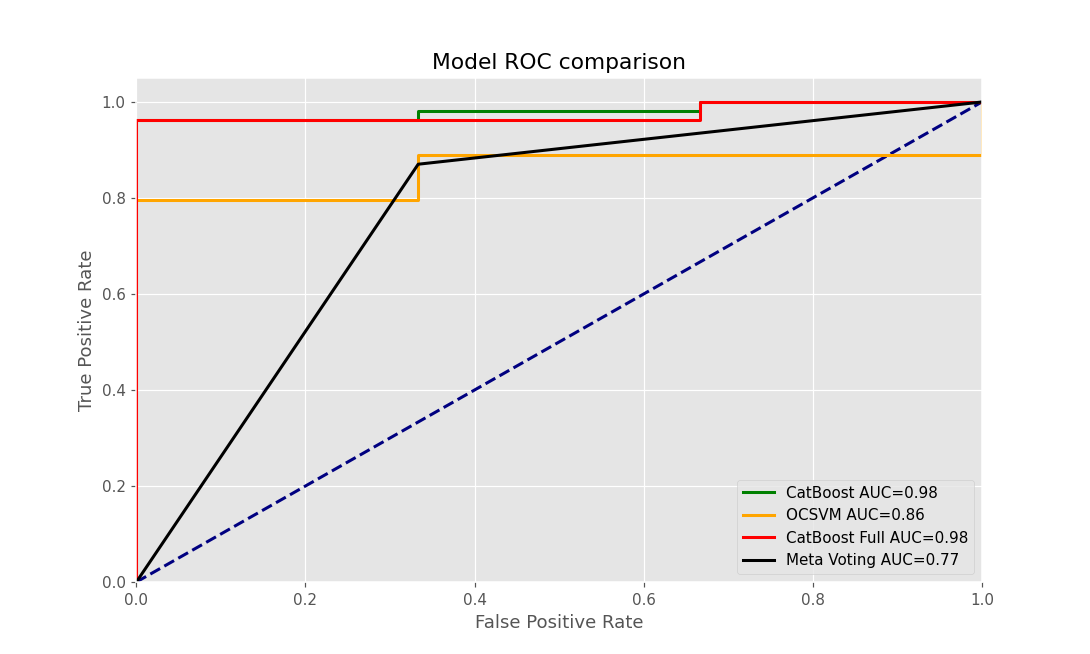

##################
CatBoost ROC threshold: 0.5
CatBoost classification report:
              precision    recall  f1-score   support

           0       0.50      0.67      0.57         3
           1       0.98      0.96      0.97        54

    accuracy                           0.95        57
   macro avg       0.74      0.81      0.77        57
weighted avg       0.96      0.95      0.95        57

CatBoost confusion matrix:
[[ 2  1]
 [ 2 52]]
##################
OCSVM ROC threshold: 0.5
OCSVM classification report:
              precision    recall  f1-score   support

           0       0.22      0.67      0.33         3
           1       0.98      0.87      0.92        54

    accuracy                           0.86        57
   macro avg       0.60      0.77      0.63        57
weighted avg       0.94      0.86      0.89        57

OCSVM confusion matrix:
[[ 2  1]
 [ 7 47]]
##################
CatBoost Full ROC threshold: 0.5
CatBoost Full classification report:
              pr

In [23]:
multi_model_perf(y_test, [test_data['cat_cl_pred'], test_data['ocsvm_pred'],
                       test_data['full_y_pred'], test_data['meta_voting_pred_label']], 
              ['CatBoost', 'OCSVM',
               'CatBoost Full', 'Meta Voting'], report_threshold=[0.5,0.5,0.5,0.9,0.5])

In [24]:
print('Hardest rendition types:')
test_data['full_y_pred_lab'] = test_data['full_y_pred']>0.5
test_data[test_data.full_y_pred_lab!=test_data.target].groupby('rendition').rendition.count().sort_values().tail(15)

Hardest rendition types:


rendition
1080p_watermark-345x114_24-60fps_gpu    1
144p_30-60fps                           1
480p_watermark-345x114_50-30fps_gpu     1
Name: rendition, dtype: int64

In [25]:
print('Feature importance:')
importance = catboost_full.get_feature_importance(prettified=True)
importance['Feature Name']=np.array(FULL_FEATURES)[importance['Feature Id'].values.astype(np.int32)]
importance

Feature importance:


,Feature Id,Importances,Feature Name
0,4,27.289888,temporal_threshold_gaussian_difference-mean
1,0,21.323844,size_dimension_ratio
2,1,20.522501,temporal_dct-mean
3,3,18.282202,temporal_gaussian_mse-mean
4,2,12.581565,temporal_gaussian_difference-mean


In [26]:
print('FPS Renditions')
fps_test_idx = test_data.id.str.contains('fps')
y_test_fps = test_data[fps_test_idx]['target']
multi_model_perf(y_test_fps, [test_data[fps_test_idx]['meta_y_pred'], test_data[fps_test_idx]['cat_cl_pred'], test_data[fps_test_idx]['ocsvm_pred_label'],
                       test_data[fps_test_idx]['full_y_pred'], test_data[fps_test_idx]['meta_voting_pred_label']], 
              ['Metamodel','CatBoost', 'OCSVM',
               'CatBoost Full', 'Meta Voting'], report_threshold=[0.5,0.5,0.5,0.9,0.5])

FPS Renditions


KeyError: 'meta_y_pred'

GPU Renditions


<IPython.core.display.Javascript object>


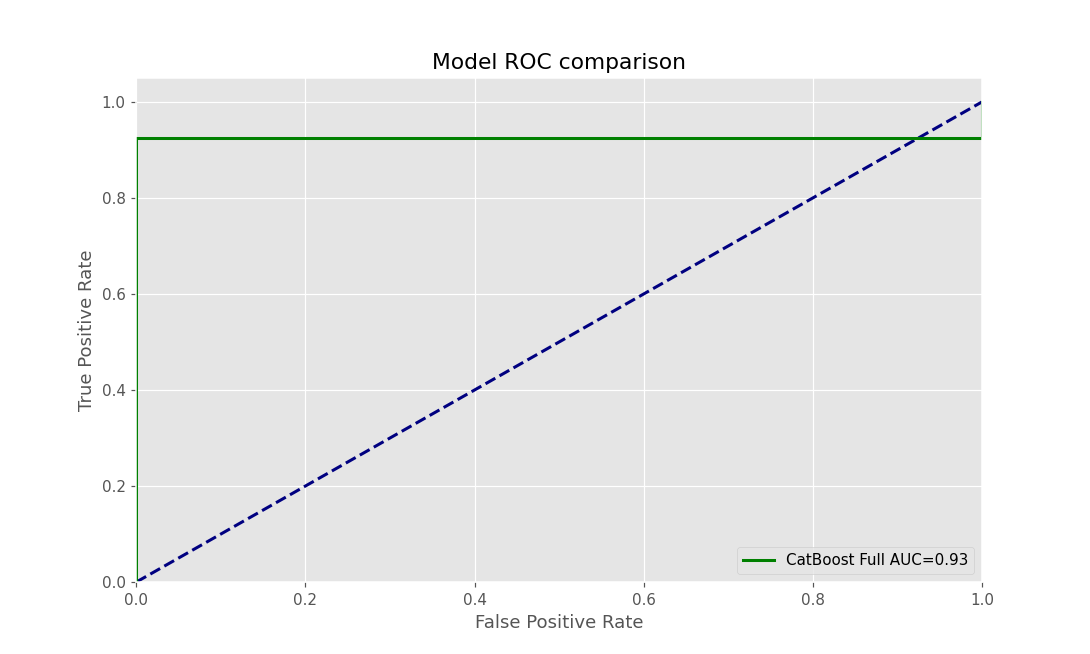

##################
CatBoost Full ROC threshold: 0.5
CatBoost Full classification report:
              precision    recall  f1-score   support

           0       0.33      1.00      0.50         1
           1       1.00      0.93      0.96        27

    accuracy                           0.93        28
   macro avg       0.67      0.96      0.73        28
weighted avg       0.98      0.93      0.95        28

CatBoost Full confusion matrix:
[[ 1  0]
 [ 2 25]]


In [27]:
print('GPU Renditions')
gpu_test_idx = test_data.id.str.contains('gpu')
y_test_fps = test_data[gpu_test_idx]['target']
gpu_test_data = test_data[gpu_test_idx]
multi_model_perf(y_test_fps, [gpu_test_data['full_y_pred']], 
              ['CatBoost Full'], report_threshold=[0.5])

In [22]:
len(data[data.id.str.contains('fps')])

5397